In [10]:
import os
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from matplotlib import gridspec
import datetime as dt
import re
from scipy.signal import spectrogram
from matplotlib.colors import Normalize

#%cd /Users/adriangutierrezgomez/Documents/seizureProcessing/
%cd /media/Projects/Adrian/seizureProcessing/
from seizureProcessing.utils.get_chnames import *
from seizureProcessing.plotter.plot_lfp import *
from seizureProcessing.utils.from_micro_to_macro_names import *
from seizureProcessing.utils.from_macro_to_micro_names import *
from seizureProcessing.plotter.plot_raster import *
from seizureProcessing.utils.loadNCS import *
from seizureProcessing.utils.readMatfile import *
from seizureProcessing.utils.get_patinfo_from_path import *

/media/Projects/Adrian/seizureProcessing


In [2]:
def from_micro_to_macro_names_new(micro_list, suffix=False):
    '''transforms a list of micro channel names
    into macro channel names
    
    PARAMETERS:
    micro_list : list/np.array, list of str with 
                channel/file names 
    suffix = bool, True for appending .ncs to names
             default is False
    
    OUTPUT:
    macro_list : list, list of strings with
                 converted names
    '''
    
    NCS = '.ncs'
    
    #get rid of .ncs bit
    micro_list = [x.strip(NCS) for x in micro_list]
    
    macro_list = [] #initializing empty list
    
    #convert names
    for st in micro_list:
        print(st)
        head = st.rstrip('0123456789')
        tail = st[len(head):]
        lowercase = [x for x in range(len(st)) if st[x].islower()]
        lowercase = lowercase[0] if len(lowercase) else ''
        #print(lowercase, head[])
        if isinstance(lowercase, int):
            head = head[:lowercase]
            lowercase = st[lowercase]

        nhead = head.lstrip('RL')
        ntail = head[:-len(nhead)]


        macroname = nhead+ntail+lowercase+tail
        
        print(st, macroname)

        if suffix:
            macro_list.append(macroname+NCS)
        else:
            macro_list.append(macroname)

    return macro_list

In [ ]:
def from_macro_to_micro_names_new(micro_list, suffix=False):
    '''transforms a list of micro channel names
    into macro channel names
    
    PARAMETERS:
    micro_list : list/np.array, list of str with 
                channel/file names 
    suffix = bool, True for appending .ncs to names
             default is False
    
    OUTPUT:
    macro_list : list, list of strings with
                 converted names
    '''
    
    NCS = '.ncs'
    
    #get rid of .ncs bit
    macro_list = [x.strip(NCS) for x in micro_list]
    
    micro_list = [] #initializing empty list
    
    #convert names
    for st in macro_list:
        print(st)
        head = st.rstrip('0123456789')
        tail = st[len(head):]
        lowercase = [x for x in range(len(st)) if st[x].islower()]
        lowercase = lowercase[0] if len(lowercase) else ''
        #print(lowercase, head[])
        if isinstance(lowercase, int):
            head = head[:lowercase]
            lowercase = st[lowercase]

        nhead = head.lstrip('RL')
        ntail = head[:-len(nhead)]


        macroname = nhead+ntail+lowercase+tail
        
        print(st, macroname)

        if suffix:
            macro_list.append(macroname+NCS)
        else:
            macro_list.append(macroname)

    return macro_list

In [3]:
def get_spike_times_by_electrode(path):
    #Move electrode by electrode, region by region
    #Get all spike ocurrances by type and add them to matrix
    #return matirx
    #NOTE: it collapses MU activity to one
    
    #get list of csc channels
    csc_channels = match_cssfiles_to_chnames(path)
    #channel_names = get_chnames(path)
    
    #convert from csc filenames to matlab time_ filenames
    matfile_names = ['times_' + x.split('.')[0] +'.mat' for x in csc_channels]
    
    #initiate output variable
    matrix = []
    
    for i, ch in enumerate(matfile_names):
        try:
            matfile = loadmat(os.path.join(path, ch)) #load times_csc*.mat file
            data = matfile['cluster_class'] #get cliuster_class data
            non_zero = np.nonzero(data.T[0]) #get indices of timestamps that are non-artifacts (non-zero)
            su_where = np.where(data.T[0] == 2) ##get indices of timestamps that are SU (2)
            mu_where = np.where(data.T[0] == 1)
            
            non_artifact = [data.T[1][x] for x in non_zero[0]]
            su_list = [data.T[1][x] for x in su_where[0]]
            mu_list = [data.T[1][x] for x in mu_where[0]] #get tiemstamps that are non-artifact
        except FileNotFoundError:
            non_artifact = su_list = mu_list = []
        out = [non_artifact, su_list, mu_list]
        matrix.append(out) #add array of timestamps to output matrix
    
    return matrix

In [4]:
#1) Get the names of files of interest ready

def get_fnames_for_channel(path, lch, DS_mi=True, DS_ma=True, reref_mi=True, reref_ma=True):
    #Fix path ending with /
    if os.path.basename(path) == '':
        path = os.path.split(path)[0]

    #MICRO data
    #get correct path to micro data
    if DS_mi:
        mi_path = find_dir(path, 'DS_data')
        if reref_mi:
            mi_path = find_dir(mi_path, 'reref')
    else:
        if reref:
            mi_path = find_dir(path, 'reref')
        else:
            mi_path = path

    #get file names
    if os.path.isdir(mi_path) and len(os.listdir(mi_path)): 
        if DS_mi or reref_mi:
            mi_chnames, data_mi, times_mi = get_matfile_chnames(mi_path)
        else:
            mi_chnames = get_chnames(path)
            data_mi = mi_chnames
            times_mi = mi_chnames
    else:
        print(f'no data avaiable in {mi_path}')
        print('check DS_mi and/or rere_mi variables')
        return None

    #filter list of names
    wh = mi_chnames.index(lch+".ncs")
    wh_copy = wh
    mi_chname = mi_chnames[wh]
    mi_data = data_mi[wh]
    mi_times = times_mi[wh]

    #MACRO data
    macro_path = find_dir(path, 'macro')

    if not os.path.isdir(macro_path) and not len(os.path.listdir(macro_path)):
        print('no macro folder found')
        return
    else:
        #transform channel name to macro format
        ch_ma = from_micro_to_macro_names_new([lch])[0][:-1]+"1"
        
        #get correct path to macro data
        if DS_ma:
            ma_path = find_dir(macro_path, 'DS_data')
            if reref_ma:
                ma_path = find_dir(ma_path, 'reref')
        else:
            if reref_ma:
                ma_path = find_dir(macro_path, 'reref')
            else:
                ma_path = macro_path
        
        
        #check if DS and reref data are available
        ####ds_path_ma = find_dir(macro_path, 'DS_data')
        ###reref_path_ma = find_dir(ds_path_ma, "reref")

        if os.path.isdir(ma_path) and len(os.listdir(ma_path)): 
            ###DS_ma = True
            if DS_ma or reref_ma:
                ma_chnames, data_ma, times_ma = get_matfile_chnames(ma_path)
                #ch_ma = ch_ma+'_reref_data.mat'
            else:
                ma_chnames = get_chnames(macro_path)
                data_ma = ma_chnames
                times_ma = ma_chnames
        else:
            print(f'no data avaiable in {mi_path}')
            print('check DS_mi and/or rere_mi variables')
            return None

        #filter list of names
        new_list = [x.strip('.ncs') for x in ma_chnames]
        ma_chnames = new_list
        try:
            wh = ma_chnames.index(ch_ma)
        except ValueError:
            new_ch_ma = re.sub('\d', '7', ch_ma) #possibly bipolar montage
            ch_ma = new_ch_ma
            wh = ma_chnames.index(ch_ma)
        ma_chname = ma_chnames[wh]
        ma_data = data_ma[wh]
        ma_times = times_ma[wh]

    #Unit data
    csc_channels = match_cssfiles_to_chnames(path)
    mx = get_spike_times_by_electrode(path)
    unit_chname = csc_channels[wh_copy]
    unit_data = mx[wh_copy]
    unit_path = path
    
    output = (
        (mi_path, mi_chname, mi_data, mi_times),
        (ma_path, ma_chname, ma_data, ma_times),
        (unit_path, unit_chname, unit_data))
    return output

In [5]:
def load_micro_macro_data(mi, ma, units, DS_mi, DS_ma, reref_mi, reref_ma, offset=0, period=8*60):

    #Load data into variables

    chname = mi[1].split('.')[0]
    ma_path = ma[0]
    mi_path = mi[0]
    #print(ma_path, ma[2])
    '''    #load macro data
    if DS_ma:
        mafile = readMatfile(os.path.join(ma_path, ma[2]))
        try:
            ma_dat = mafile.DS_data
            ma_sf = mafile.DS_freq
        except AttributeError:
            ma_dat = matfile.reref_data
    else:
        mafile = loadNCS(os.path.join(ma_path, ma[1]+'.ncs'))
        ma_dat = mafile.csc
        ma_sf = mafile.sf

    del mafile'''

    #load micro data
    if DS_mi or reref_mi:
        mifile = readMatfile(os.path.join(mi_path, mi[2]))
        try:
            mi_dat = mifile.DS_data
            mi_sf = mifile.DS_freq
            if type(mi_sf) is not int: #handling exception from old DS_data mat format
                mi_sf = mi_sf[0]
        except AttributeError:
            mi_dat = mifile.reref_data
            mi_sfdat = readMatfile(os.path.join(mi_path, mi[3]))
            mi_sf = int(1/(mi_sfdat.reref_times[1]-mi_sfdat.reref_times[0])*1e6)
            del mi_sfdat
    else:
        mifile = loadNCS(os.path.join(mi_path, mi[1]))
        mi_dat = mifile.csc
        mi_sf = mifile.sf

    del mifile

    #load macro data
    if DS_ma or reref_ma:
        mafile = readMatfile(os.path.join(ma_path, ma[2]))
        try:
            ma_dat = mafile.DS_data
            ma_sf = mafile.DS_freq
            if type(ma_sf) is not int: #handling exception from old DS_data mat format
                ma_sf = ma_sf[0]
        except AttributeError:
            ma_dat = mafile.reref_data
            ma_sfdat = readMatfile(os.path.join(ma_path, ma[3]))
            ma_sf = int(1/(ma_sfdat.reref_times[1]-ma_sfdat.reref_times[0])*1e6)
            #del ma_sfdat
    else:
        mafile = loadNCS(os.path.join(ma_path, ma[1]))
        ma_dat = mafile.csc*mafile.volt_scalar
        ma_sf = mafile.sf

    del mafile

    #load timestamps
    tsfile = loadNCS(os.path.join(path, units[1]))
    tsfile.get_timestamps()
    ts = tsfile.ts
    sf = tsfile.sf

    del tsfile

    #calculate offset and period
    o = max(0, int(int(offset)*sf))
    p = min(len(ts), int(int(offset+period)*sf))
    #print(len(ts), o, p, ts[o], ts[p])
    assert p>o

    o_mi = max(0, int(int(offset)*mi_sf))
    o_ma = max(0, int(int(offset)*ma_sf))

    p_mi = min(len(ts), int(int(offset+period)*mi_sf))
    p_ma = min(len(ts), int(int(offset+period)*ma_sf))
    assert p_mi>o_mi
    assert p_ma>o_ma
    
    #cut data
    mi_dat = mi_dat[o_mi:p_mi]
    ma_dat = ma_dat[o_ma:p_ma]
    
    mx = units[2]
    for i, val in enumerate(mx):
        if len(val):
            new_ts = [val[x]*1e3 for x in range(len(val)) if val[x]*1e3>=ts[o] and val[x]*1e3<=ts[p-1]]
        else:
            new_ts = []
        mx[i] = new_ts
    
    ts = ts[o:p]
    return ts, mi_dat, ma_dat, mx, sf

In [6]:
def plot_trimodal_per_channel(ts, ma_dat, mi_dat, mx, path, sf, lch, period, mode='datetime', artifacts=False, title=True, 
                              save=True, label='', folder_name='plots_trimodal', fmin=0, fmax=30, spec_vmin=None, spec_vmax=None):
    #set plot params
    my_dpi = 96
    fig = plt.figure(figsize=(1900/my_dpi, 1024/my_dpi))
    #fig, ax = plt.subplots(3,1, figsize=(1900/my_dpi, 1024/my_dpi))
    #gs = gridspec.GridSpec(6, 2, height_ratios=[1,0.5,1,0.5,2,0.5], width_ratios=[1,0.01]) 
    gs = gridspec.GridSpec(6, 1, height_ratios=[1,0.5,1,0.5,2,0.5])
    #ax2 = plt.subplot(gs[2])
    '''ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2], sharex = ax0)
    ax2 = plt.subplot(gs[4], sharex = ax0)
    ax3 = plt.subplot(gs[6], sharex = ax0)
    ax4 = plt.subplot(gs[8], sharex = ax0)
    ax5 = plt.subplot(gs[10], sharex = ax0)
    
    ax6 = fig.add_subplot(gs[1], sharey=ax0)
    ax7 = fig.add_subplot(gs[3], sharey=ax1)
    ax8 = fig.add_subplot(gs[5], sharey=ax2)
    ax9 = fig.add_subplot(gs[7], sharey=ax3)
    ax10 = fig.add_subplot(gs[9], sharey=ax4)
    ax11 = fig.add_subplot(gs[11], sharey=ax5)'''
    
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex = ax0)
    ax2 = plt.subplot(gs[2], sharex = ax0)
    ax3 = plt.subplot(gs[3], sharex = ax0)
    ax4 = plt.subplot(gs[4], sharex = ax0)
    ax5 = plt.subplot(gs[5], sharex = ax0)

    #calculate xaxis for macro and micro
    xax_ma = np.linspace(ts[0], ts[-1], len(ma_dat))
    xax_mi = np.linspace(ts[0], ts[-1], len(mi_dat))

    #PLOT MACRO DATA
    ax0.plot(xax_ma, ma_dat)
    
    #calculate spectrogram
    f_ma, t_ma, spg_ma = spectrogram(ma_dat, fs=sf, nperseg=200, noverlap=150, scaling='density')
    if not spec_vmin:
        spec_vmin = -fmax
    if not spec_vmax:
        spec_vmax = fmax
    #plot spectrogram
    spec_ma = ax1.imshow(20*np.log10(spg_ma[fmin:fmax,]), aspect='auto', cmap='hot', origin='lower',
                        extent=[min(xax_ma), max(xax_ma), min(f_ma), fmax],
                        norm=Normalize(vmin=spec_vmin*3, vmax=spec_vmax, clip=False))
    #fig.colorbar(spec_ma, cax=ax7, ax=ax7, orientation='horizontal')
    fig.colorbar(spec_ma, ax=ax1, orientation='horizontal')
    
    #PLOT MICRO DATA
    ax2.plot(xax_mi, mi_dat)
    
    #calculate spectrogram
    f_mi, t_mi, spg_mi = spectrogram(mi_dat, fs=1000, nperseg=200, noverlap=150, scaling='density')
    
    #plot spectrogram
    spec_mi = ax3.imshow(20*np.log10(spg_mi[fmin:fmax,]), aspect='auto', cmap='hot', origin='lower',
                        extent=[min(xax_ma), max(xax_ma), min(f_mi), fmax],
                        norm=Normalize(vmin=spec_vmin, vmax=spec_vmax, clip=False))#, vmin=min([min(x) for x in data_to_plot]), vmax=max([min(x) for x in data_to_plot])))
    #fig.colorbar(spec_mi, cax=ax9, ax=ax9)
    fig.colorbar(spec_mi, ax=ax3, orientation='horizontal')
    
    if not artifacts:
        #ax2.eventplot(mx[1:],linewidths=0.4, linelengths=.9, colors=['red', 'blue'], alpha=1)
        ax4.eventplot(mx[1:],linewidths=0.4, linelengths=.9, colors=['blue'], alpha=1)
    else:
        ax4.eventplot(mx,linewidths=0.4, linelengths=.9, colors=['green', 'red', 'blue'], alpha=1)
    ax4.set_xlim(ts[0], ts[-1])
    
    #calculate histogram for firingrates:
    window = np.arange(min(ts), max(ts), 1000*1e3)
    hist = []

    for i in mx:
        hist.append(np.histogram(i, window)[0])
    
    hist = np.nanmean(hist, axis=0)
    #print(hist, type(hist.shape))
    #if type(hist) == 'tuple':
    hist_xaxis = np.linspace(ts[0], ts[-1], hist.shape[0])
    ax5.plot(hist_xaxis, hist)
    #else:
    #    hist = [0*240]

    #fix plot's xaxis
    max_ts = max(ts) + (period%60)*sf
    xaxis_min = ((np.linspace(min(ts), max_ts, 10))).tolist()
    xaxis_maj = ((np.linspace(min(ts), max_ts, int(period/60)+1))).tolist()
    #hist_xaxis = 
    ax5.set_xticks(xaxis_maj)
    
    #xaxis_min_specma = ((np.linspace(min(ts), max(ts), 10))).tolist()
    #xaxis_maj_spe = ((np.linspace(min(ts), max(ts), int(int(period)/60)+1))).tolist()

    if mode == 'datetime':
        datetime_ts = [dt.datetime.utcfromtimestamp(ts[i]/1e6) for i in range(len(ts))]
        xaxis_maj_2 = datetime_ts[::sf*60]
        labels_yaxis = [(str(a).split(' ')[-1]).split('.')[0] for a in xaxis_maj_2]
        ax5.set_xticklabels(labels_yaxis, fontsize=8, fontweight='bold')
        ax5.set_xlabel('time (HH:MM:SS)', fontweight='bold', fontsize=12)
        plt.xticks(rotation=45)
    else:
        xplot = np.linspace(0, int(period), int(period))
        #xplot_spec_ma = np.linspace(0, int(period), len(t_ma))
        label_xaxis = [str(int(x)) for x in xplot]
        ax5.set_xticks(xaxis_min, minor=True)
        ax5.set_xticklabels(label_xaxis, fontsize=8, fontweight='bold')
        ax5.set_xlabel('time (min)', fontweight='bold', fontsize=15)
        #ax2.se

    #fix yaxis ticks
    ax0.set_yticks([])
    #ax0.set_xticks([])
    ax1.set_yticks(np.linspace(min(f_mi),fmax,5))
    #ax1.set_xticks([])
    ax2.set_yticks([])
    ax3.set_yticks(np.linspace(min(f_ma),fmax,5))
    ax4.set_yticks([])
    ax5.set_yticks(np.linspace(min(hist), max(hist), 3))
    
    #ax7.set_yticks([])
    #ax9.set_yticks([])
    
    spines = ('top', 'right', 'bottom')
    spines_all = ('top', 'right', 'bottom', 'left')
    
    for sp in spines:
        ax0.spines[sp].set_visible(False)
        ax1.spines[sp].set_visible(False)
        ax2.spines[sp].set_visible(False)
        ax3.spines[sp].set_visible(False)
        ax4.spines[sp].set_visible(False)
    
    '''for sp in spines_all:
        ax6.spines[sp].set_visible(False)
        ax7.spines[sp].set_visible(False)
        ax8.spines[sp].set_visible(False)
        ax9.spines[sp].set_visible(False)
        ax10.spines[sp].set_visible(False)
        ax11.spines[sp].set_visible(False)'''
    '''ax0.spines[('top', 'right', 'bottom')].set_visible(False)
    #ax0.spines['right'].set_visible(False)
    #ax0.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['bottom'].set_visible(False)'''
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)
    #ax5.spines['bottom'].set_visible(False)

    #set yaxis labels
    ax0.set_ylabel(ma[1], fontweight='bold', fontsize=12)
    ax1.set_ylabel('freq (Hz)', fontweight='bold', fontsize=12)
    ax2.set_ylabel(mi[1].split('.')[0], fontweight='bold', fontsize=12)
    ax3.set_ylabel('freq (Hz)', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Units', fontweight='bold', fontsize=12)
    ax5.set_ylabel('mean FR (Hz)', fontweight='bold', fontsize=12)

    #if not artifacts:
    #    ax2.legend(["SU", "MU"], loc='upper right')
    #else:
    #    ax2.legend(["Artifact", "SU", "MU"], loc='upper right')


    plt.subplots_adjust(hspace=.0)
    #plt.grid(visible=True, which='major', axis='x', linewidth=0.8, color='k')
    #plt.show()

    #get figure title
    if mode=='datetime':
        title_datetime_str = dt.datetime.strftime(datetime_ts[0], '%Y-%m-%d_%H-%M-%S')
    else:
        title_datetime_str = dt.datetime.strftime(dt.datetime.utcfromtimestamp(ts[0]/1e6), 
                                                  '%Y-%m-%d_%H-%M-%S')
    #set figure title
    if title:
        #get patient number and seizure number
        expr = re.compile('(.*)(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})(.*)')
        match = expr.search(path)
        session = match.group(2)
        basepath = find_dir(path, session)
        pnr, snr = get_patinfo_from_path(basepath)


        #figure title
        fig.suptitle(f'Patient {pnr} seizure {snr} ({title_datetime_str})', 
                     fontweight="bold", fontsize=16)
    if save:
        print('saving plot...')
        #Fix path ending with /
        if os.path.basename(path) == '':
            path = os.path.split(path)[0]
        
        out_path = os.path.join(path, folder_name)
        if not os.path.exists(out_path):
            print('created /plots_trimodal directory')
            os.mkdir(out_path)
        
        figname = out_path + '/' + title_datetime_str + '_' + lch + '_trimodal'
        if len(label):
             figname = figname + '_' + label
        
        figname += '.eps'
        
        plt.savefig(figname, dpi=my_dpi, format='eps')
        print(f'figure {figname} saved in {path}') 

In [108]:
#tester
#path = "/Volumes/ExtremeSSD/Data/094/2021-12-11_04-34-59/"
path = "/media/Seizures/60min_cut/081/2019-12-11_17-55-33/"
mi_DS = True
ma_DS = True
mi_reref = True
ma_reref = True
offset = (30*60)-60
period = (3*60)+30


channels = [x.split('.')[0] for x in get_chnames(path) if 'AH' in x]

for lch in channels:
    print(f'plotting {lch}...')
    mi, ma, units = get_fnames_for_channel(path, lch, mi_DS, ma_DS, mi_reref, ma_reref)

    ts, mi_dat, ma_dat, mx, sf = load_micro_macro_data(mi, ma, units, mi_DS, ma_DS, mi_reref, ma_reref,
                                                       offset, period)

    plot_trimodal_per_channel(ts, ma_dat, mi_dat, mx, path, sf, lch, period, mode='time', fmin=0, fmax=50, spec_vmin=-40)

plotting RAH1...
RAH1
RAH1 AHR1


KeyboardInterrupt: 

In [54]:
channels

['RAH1', 'RAH2', 'RAH3', 'RAH4', 'RAH5', 'RAH6', 'RAH7', 'RAH8']

In [26]:
path = "/media/Seizures/60min_cut/081/2019-12-11_17-55-33/"
regions = get_region_name(path)
csclist = match_cssfiles_to_chnames(path)
chlist = get_chnames(path)

csc_inreg = [csclist[i].strip('.ncs') for i, ch in enumerate(chlist) if ch in regions['RTa']]

In [32]:
regions

{'RAH': ['RAH1.ncs',
  'RAH2.ncs',
  'RAH3.ncs',
  'RAH4.ncs',
  'RAH5.ncs',
  'RAH6.ncs',
  'RAH7.ncs',
  'RAH8.ncs'],
 'RTa': ['RTa1.ncs',
  'RTa2.ncs',
  'RTa3.ncs',
  'RTa4.ncs',
  'RTa5.ncs',
  'RTa6.ncs',
  'RTa7.ncs',
  'RTa8.ncs'],
 'RTb': ['RTb1.ncs',
  'RTb2.ncs',
  'RTb3.ncs',
  'RTb4.ncs',
  'RTb5.ncs',
  'RTb6.ncs',
  'RTb7.ncs',
  'RTb8.ncs'],
 'RTc': ['RTc1.ncs',
  'RTc2.ncs',
  'RTc3.ncs',
  'RTc4.ncs',
  'RTc5.ncs',
  'RTc6.ncs',
  'RTc7.ncs',
  'RTc8.ncs']}

In [31]:
get_matfile_chnames(os.path.join(path, 'DS_data/reref'))

(['RAH1.ncs',
  'RAH2.ncs',
  'RAH3.ncs',
  'RAH4.ncs',
  'RAH5.ncs',
  'RAH6.ncs',
  'RAH7.ncs',
  'RAH8.ncs',
  'RTa1.ncs',
  'RTa2.ncs',
  'RTa3.ncs',
  'RTa4.ncs',
  'RTa5.ncs',
  'RTa6.ncs',
  'RTa7.ncs',
  'RTa8.ncs',
  'RTb1.ncs',
  'RTb2.ncs',
  'RTb3.ncs',
  'RTb4.ncs',
  'RTb5.ncs',
  'RTb6.ncs',
  'RTb7.ncs',
  'RTb8.ncs',
  'RTc1.ncs',
  'RTc2.ncs',
  'RTc3.ncs',
  'RTc4.ncs',
  'RTc5.ncs',
  'RTc6.ncs',
  'RTc7.ncs',
  'RTc8.ncs'],
 ['CSC1_reref_data.mat',
  'CSC2_reref_data.mat',
  'CSC3_reref_data.mat',
  'CSC4_reref_data.mat',
  'CSC5_reref_data.mat',
  'CSC6_reref_data.mat',
  'CSC7_reref_data.mat',
  'CSC8_reref_data.mat',
  'CSC9_reref_data.mat',
  'CSC10_reref_data.mat',
  'CSC11_reref_data.mat',
  'CSC12_reref_data.mat',
  'CSC13_reref_data.mat',
  'CSC14_reref_data.mat',
  'CSC15_reref_data.mat',
  'CSC16_reref_data.mat',
  'CSC17_reref_data.mat',
  'CSC18_reref_data.mat',
  'CSC19_reref_data.mat',
  'CSC20_reref_data.mat',
  'CSC21_reref_data.mat',
  'CSC22_reref

In [127]:
def get_fnames_for_channel_region(path, DS_mi=True, DS_ma=True, reref_mi=True, reref_ma=True):
    #Fix path ending with /
    if os.path.basename(path) == '':
        path = os.path.split(path)[0]

    #MICRO data
    #get correct path to micro data
    if DS_mi:
        mi_path = find_dir(path, 'DS_data')
        if reref_mi:
            mi_path = find_dir(mi_path, 'reref')
    else:
        if reref:
            mi_path = find_dir(path, 'reref')
        else:
            mi_path = path
            
    #get file names
    regions = get_region_name(path)
    #csclist = match_cssfiles_to_chnames(path)
    #chlist = get_chnames(path)
    
    
    if os.path.isdir(mi_path) and len(os.listdir(mi_path)): 
        if DS_mi or reref_mi:
            mi_chnames, data_mi, times_mi = get_matfile_chnames(mi_path)
        else:
            mi_chnames = get_chnames(path)
            data_mi = mi_chnames
            times_mi = mi_chnames
    else:
        print(f'no data avaiable in {mi_path}')
        print('check DS_mi and/or rere_mi variables')
        return None

    #filter list of names
    #wh = mi_chnames.index(lch+".ncs")
    #wh_copy = wh
    mi_chname_dic, mi_data_dic, mi_times_dic = {},{},{}
    for regname, chans in regions.items():
        mi_chname_dic[regname] = [x for x in mi_chnames if x in chans]
        
        indices = [indi for indi, x in enumerate(mi_chnames) if x in chans]
        #print(indices)
        mi_data_dic[regname] = [data_mi[i] for i in indices]
        mi_times_dic[regname] = [times_mi[i] for i in indices]

    #MACRO data
    macro_path = find_dir(path, 'macro')

    if not os.path.isdir(macro_path) and not len(os.path.listdir(macro_path)):
        print('no macro folder found')
        return
    else:
        #transform channel name to macro format
        macro_ch_dic = {k:[from_micro_to_macro_names_new([mi_chname_dic[k][0].strip('.ncs')])[0][:-1]+"1"] for k in regions.keys()}
        
        #for key, val in macro_ch_dic.items():
        #    macro_ch_dic[key] = from_micro_to_macro_names_new([val[0]])[0][:-1]+"1"
        #ch_ma = from_micro_to_macro_names_new([lch])[0][:-1]+"1"
        
        #get correct path to macro data
        if DS_ma:
            ma_path = find_dir(macro_path, 'DS_data')
            if reref_ma:
                ma_path = find_dir(ma_path, 'reref')
        else:
            if reref_ma:
                ma_path = find_dir(macro_path, 'reref')
            else:
                ma_path = macro_path
        
        
        #check if DS and reref data are available
        ####ds_path_ma = find_dir(macro_path, 'DS_data')
        ###reref_path_ma = find_dir(ds_path_ma, "reref")

        if os.path.isdir(ma_path) and len(os.listdir(ma_path)): 
            ###DS_ma = True
            if DS_ma or reref_ma:
                ma_chnames, data_ma, times_ma = get_matfile_chnames(ma_path)
                #ch_ma = ch_ma+'_reref_data.mat'
            else:
                ma_chnames = get_chnames(macro_path)
                data_ma = ma_chnames
                times_ma = ma_chnames
        else:
            print(f'no data avaiable in {mi_path}')
            print('check DS_mi and/or rere_mi variables')
            return None
        #print(ma_chnames)
        #filter list of names
        #new_list = [x.strip('.ncs') for x in ma_chnames]
        #ma_chnames = new_list
        #try:
        #    wh = ma_chnames.index(ch_ma)
        #except ValueError:
        #    new_ch_ma = re.sub('\d', '7', ch_ma) #possibly bipolar montage
        #    ch_ma = new_ch_ma
        #    wh = ma_chnames.index(ch_ma)
        #ma_chname = ma_chnames[wh]
        ma_data_dic = {}
        ma_times_dic = {}
        
        for key, val in macro_ch_dic.items():
            #print(val)
            wh = ma_chnames.index(val[0]+'.ncs')
            
            ma_data_dic[key] = data_ma[wh]
            ma_times_dic[key] = times_ma[wh]
    
        ma_data = data_ma[wh]
        ma_times = times_ma[wh]

    #Unit data
    csc_channels = match_cssfiles_to_chnames(path)
    
    #print(csc_channels,mi_data_dic)
    mx = get_spike_times_by_electrode(path)
    unit_chname = mi_chname_dic
    unit_data = mx
    unit_dic = {reg:[] for reg in ma_data_dic.keys()}
    unit_path = path
    
    
    for key, val in mi_chname_dic.items():
        indices = [i for i,x in enumerate(mi_chnames) if x in val]
        #print(indices)
        unit_dic[key] = [mx[u][:] for u in indices]
        
    output = (
        (mi_path, mi_chname_dic, mi_data_dic, mi_times_dic),
        (ma_path, macro_ch_dic, ma_data_dic, ma_times_dic),
        (unit_path, unit_chname, unit_dic))
    return output

In [176]:
mi, ma, units = get_fnames_for_channel_region(path)

RAH1
RAH1 AHR1
RTa1
RTa1 TRa1
RTb1
RTb1 TRb1
RTc1
RTc1 TRc1


In [173]:
ma[2]['RTa']

'TRa2_reref_data.mat'

RAH
figure RAH_trimodal.eps saved in /media/Seizures/60min_cut/081/2019-12-11_17-55-33/
RTa
figure RTa_trimodal.eps saved in /media/Seizures/60min_cut/081/2019-12-11_17-55-33/
RTb


/tmp/ipykernel_88491/2751343684.py:131: RuntimeWarning: Mean of empty slice
  hist = np.nanmean(hist, axis=0)


IndexError: tuple index out of range

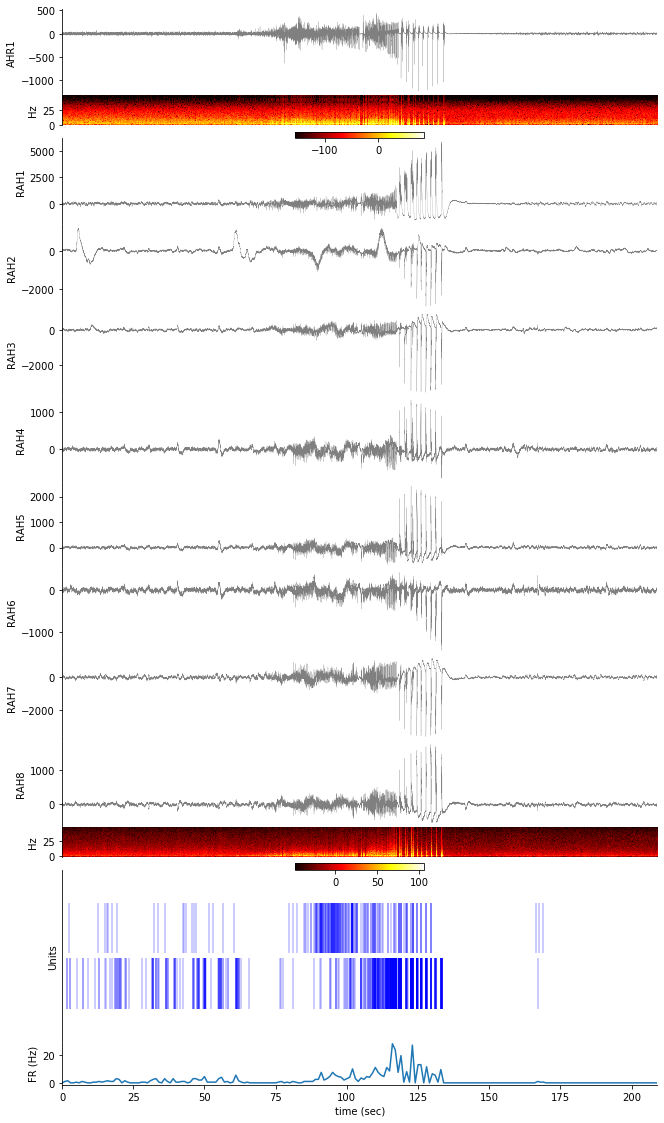

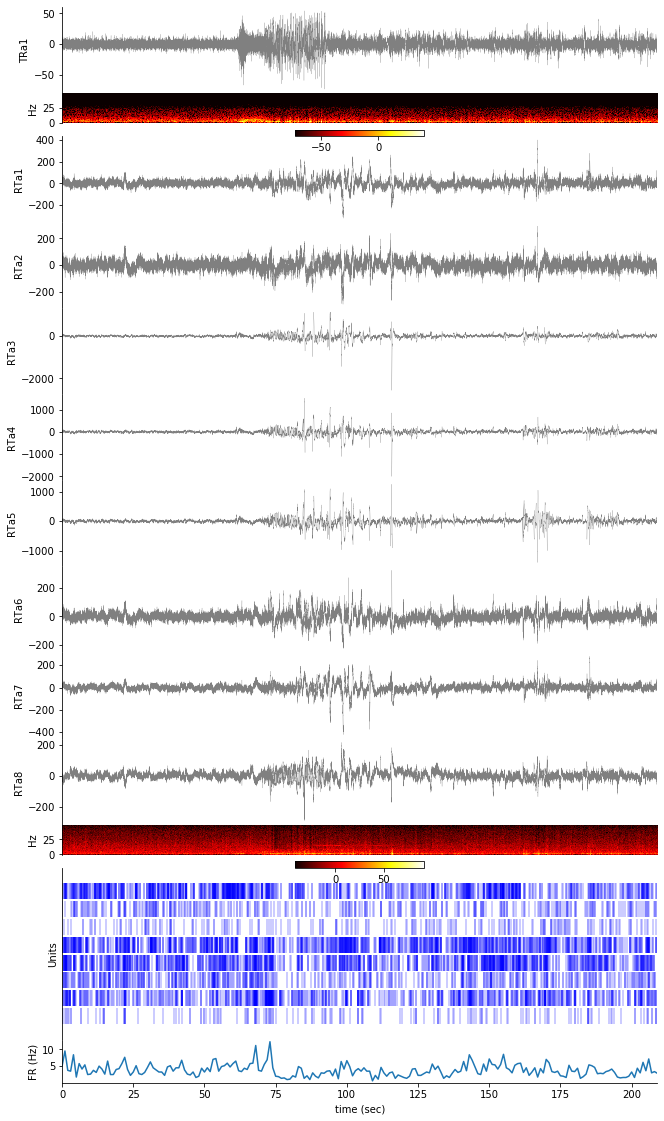

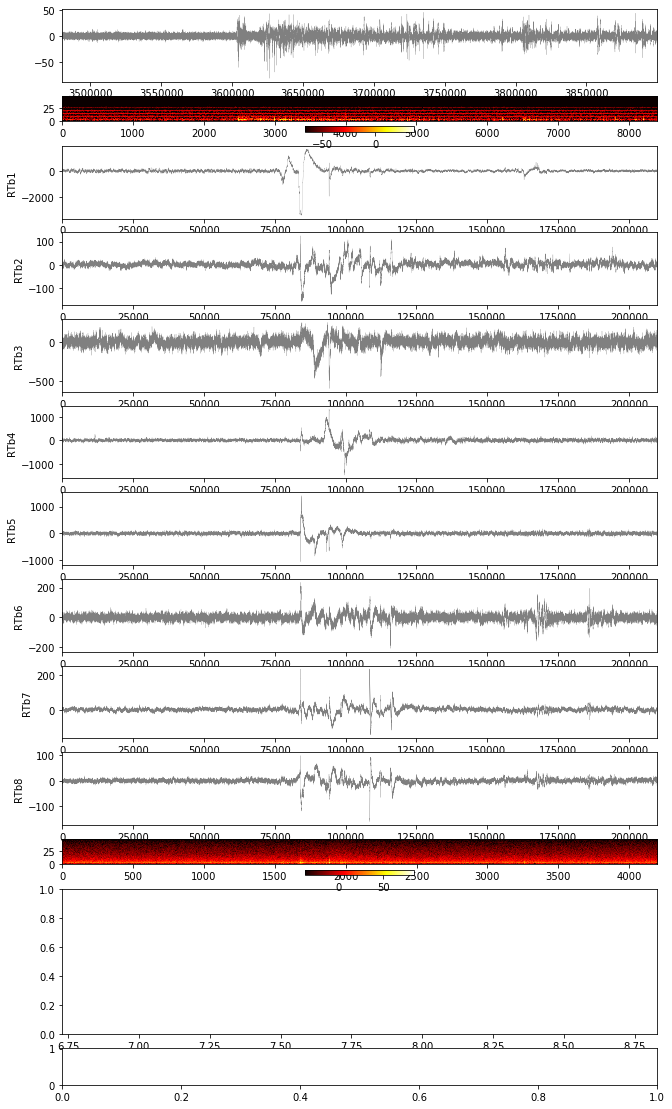

In [257]:
savepath_new = '/media/Seizures/Wenzel/regional_trimodal/'
offset = (30*60)-60
period = (3*60)+30
    

for reg, channels in mi[1].items():
    print(reg)
    #nr_rows = len(chan)+1 + len(ma[1][reg])*2 + 2
    
    my_dpi = 96
    fig = plt.figure(figsize=(1024/my_dpi, 1900/my_dpi))
    gs = gridspec.GridSpec(13, 1, height_ratios=[1,0.5,1,1,1,1,1,1,1,1,0.5,2,0.5])
    
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3], sharex = ax2)
    ax4 = plt.subplot(gs[4], sharex = ax2)
    ax5 = plt.subplot(gs[5], sharex = ax2)
    ax6 = plt.subplot(gs[6], sharex = ax2)
    ax7 = plt.subplot(gs[7], sharex = ax2)
    ax8 = plt.subplot(gs[8], sharex = ax2)
    ax9 = plt.subplot(gs[9], sharex = ax2)
    ax10 = plt.subplot(gs[10])
    ax11 = plt.subplot(gs[11])
    ax12 = plt.subplot(gs[12])
    #ax13 = plt.subplot(gs[13], sharex = ax0)
    
    
    #get ma data
    mapath = ma[0]
    mafname = ma[2][reg]
    
    mafile = readMatfile(os.path.join(mapath, mafname))
    ma_dat = mafile.reref_data
    ma_sfdat = readMatfile(os.path.join(mapath, ma[3][reg]))
    ma_sf = int(1/(ma_sfdat.reref_times[1]-ma_sfdat.reref_times[0])*1e6)
    
    ma_xax = np.arange(0, len(ma_dat))
    o_ma = offset*ma_sf
    p_ma = period*ma_sf
    end_ma = o_ma + p_ma
    
    ma_dat_toplot = ma_dat[o_ma:end_ma]
    ma_xax_toplot = ma_xax[o_ma:end_ma]
    f_ma, t_ma, spg_ma = spectrogram(ma_dat_toplot, fs=ma_sf, nperseg=150, noverlap=100, scaling='density')
    spec_toplot = 20*np.log10(spg_ma)
    #print(len(ma_dat_toplot))
    ax0.plot(ma_xax_toplot,ma_dat_toplot, 'gray', linewidth=0.2)
    ax0.set_xlim(min(ma_xax_toplot), max(ma_xax_toplot))
    spec_ma = ax1.imshow(spec_toplot[:50,], aspect='auto', cmap='hot', origin='lower',
                        norm=Normalize(vmin=spec_toplot.max()*-1.8, vmax=spec_toplot.max(), clip=False))
    fig.colorbar(spec_ma, ax=ax1, orientation='horizontal')
    
    mi_axis = [ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    mi_path = mi[0]
    mean_mispg = []
    for index, chan in enumerate(channels):
        mi_datafname = mi[2][reg][index]
        mi_timefname = mi[3][reg][index]
        
        mi_dfile = readMatfile(os.path.join(mi_path,mi_datafname))
        mi_tfile = readMatfile(os.path.join(mi_path,mi_timefname))
        
        mi_data = mi_dfile.reref_data
        mi_sf = int(1/(mi_tfile.reref_times[1]-mi_tfile.reref_times[0])*1e6)
        
        o_mi = offset*mi_sf
        p_mi = period*mi_sf
        end_mi = o_mi + p_mi
        
        mi_data_toplot = mi_data[o_mi:end_mi]
        mixax = np.arange(0, len(mi_data_toplot))
        
        mi_axis[index].plot(mixax, mi_data_toplot, 'gray', linewidth=0.2)
        mi_axis[index].set_xlim(min(mixax), max(mixax))
        mi_axis[index].set_ylabel(chan.strip('.ncs'))
        
        f_ma, t_ma, spg_mi = spectrogram(mi_data_toplot, fs=mi_sf, nperseg=150, noverlap=100, scaling='density')
        
        mean_mispg.append(spg_mi)
    
    spg_mean = np.nanmean(mean_mispg, axis=0)
    spec_toplot = 20*np.log10(spg_mean)
    spec_mi = ax10.imshow(spec_toplot[:50,], aspect='auto', cmap='hot', origin='lower',
                        norm=Normalize(vmin=spec_toplot.max()*-0.45, vmax=spec_toplot.max(), clip=False))
    fig.colorbar(spec_mi, ax=ax10, orientation='horizontal')
    #load timestamps
    tsfile = loadNCS(os.path.join(path, 'CSC1.ncs'))
    tsfile.get_timestamps()
    ts = tsfile.ts
    sf_u = tsfile.sf
    
    o_units = offset*sf_u
    p_units = period*sf_u
    end_unit = o_units+p_units
    del tsfile
    
    #plot units
    mx = units[2][reg]
    new_mx = []
    for m in mx:
        for unit in m[1:]:
            if len(unit):
                new_mx.append(unit)
    
    #_new_mx = []
    #for nunit in new_mx:
    #    _nunit = [x for x in nunit if x<ts[end_unit] & x> ts[o_units]]
    #    _new_mx.append(_nunit)
    
    
    _new_mx = []
    for i, val in enumerate(new_mx):
        #print(len(val))
        new_ts = [val[x]*1e3 for x in range(len(val)) if val[x]*1e3>=ts[o_units]and val[x]*1e3<=ts[end_unit-1]]
        _new_mx.append(new_ts)
    ax11.eventplot(_new_mx,linewidths=0.4, linelengths=.9, colors=['blue'], alpha=1)
    ax11.set_xlim(ts[o_units], ts[end_unit])
    
    
    
    
    #calculate histogram for firingrates:
    window = np.arange(ts[o_units], ts[end_unit], 1000*1e3)
    hist = []

    for i in _new_mx:
        hist.append(np.histogram(i, window)[0])
    
    hist = np.nanmean(hist, axis=0)
    #print(hist, type(hist.shape))
    #if type(hist) == 'tuple':
    #hist_xaxis = np.linspace(ts[o_units], ts[end_unit], hist.shape[0])
    hist_xaxis = np.arange(0, hist.shape[0])
    ax12.plot(hist_xaxis, hist)
    ax12.set_xlim(min(hist_xaxis), max(hist_xaxis))
    ax12.set_xlabel('time (sec)')
    
    
    spines = ('top', 'right', 'bottom')
    #spines_all = ('top', 'right', 'bottom', 'left')
    axis_to_remove_spines = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
    
    for axx in axis_to_remove_spines:
        for sp in spines:
            axx.spines[sp].set_visible(False)
        axx.set_xticks([])
    
    ax12.spines['top'].set_visible(False)
    ax12.spines['right'].set_visible(False)
    
    ax11.set_yticks([])
    ax11.set_ylabel('Units')
    ax12.set_ylabel('FR (Hz)')
    
    ax0.set_ylabel(ma[1][reg][0])
    ax1.set_ylabel('Hz')
    ax10.set_ylabel('Hz')
    plt.subplots_adjust(hspace=.0)
    
    
    figname = f"{reg}_trimodal.eps"
    
    
        
    plt.savefig(os.path.join(savepath_new, figname), dpi=my_dpi, format='eps')
    print(f'figure {figname} saved in {path}') 

In [224]:
units[0]

'/media/Seizures/60min_cut/081/2019-12-11_17-55-33'

In [203]:
mx = units[2][reg]

In [218]:
new_mx = []
for m in mx:
    for unit in m[1:]:
        if len(unit):
            new_mx.append(unit)

In [226]:
units[0]

'/media/Seizures/60min_cut/081/2019-12-11_17-55-33'

In [244]:
ma[1]

{'RAH': ['AHR1'], 'RTa': ['TRa1'], 'RTb': ['TRb1'], 'RTc': ['TRc1']}